In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Javascript


sns.set_style('darkgrid')

import sys
sys.path.append('../inverse_rendering/')
from general_imports import *
from tqdm import tqdm as tqdm_file
import argparse
import string
import random


from numpy import asarray
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from numpy import argsort
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed

alphanumeric_key = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
print("Key is: %s"%alphanumeric_key)

class Jupyter_Argparse:
    def __init__(self, model_file, pickle_file):
        self.models_pickle_file_name = models_pickle_file_name
        self.model_file_name = model_file_name

/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py
/net/storage001.ib.cluster/om2/user/smadan/training_scaffold_own/res/loader/multi_attribute_loader.py
/net/storage001.ib.cluster/om2/user/smadan/training_scaffold_own/res/loader
/net/storage001.ib.cluster/om2/user/smadan/training_scaffold_own/res/loader/loader.py
/net/storage001.ib.cluster/om2/user/smadan/training_scaffold_own/res/loader
Key is: rN3MhUtORei6kkH1


In [2]:
import cma

In [11]:
# model_file_name = "resnet"

In [17]:
# model_file_name = "resnet18_antialiased_v7_40_normalized_final.pt"
model_file_name = "resnet18_v7_40.pt"
models_pickle_file_name = "categories_10_models_10.pkl"
args = Jupyter_Argparse(model_file_name, models_pickle_file_name)
# parser.add_argument('--model_file_name', type = str, required = True)
# parser.add_argument('--models_pickle_file_name', type = str, required = True)
# args = parser.parse_args()

# DATASET_NAME = args.dataset_name
MODEL_FILE_NAME = args.model_file_name
SAVE_FOLDER_NAME = MODEL_FILE_NAME.split('.pt')[0]
MODELS_PICKLE_FILE_NAME = args.models_pickle_file_name

In [19]:
##### Load Model #####
model_path = '../training_models/saved_models/%s'%MODEL_FILE_NAME

# model_path = '../training_models/saved_models/resnet18_antialiased_v7_normalized_final.pt'
# model_path = '../training_models/saved_models/resnet18_v7_subsampled_normalized_final.pt'
# model_path = '../training_models/saved_models/resnet18_v7_places_normalized.pt'
# model_path = '../training_models/saved_models/resnet18_v7_40_final.pt'
# model_path = '../training_models/saved_models/resnet18_v7_truly_shift_invariant_normalized_final.pt'
loaded_model = torch.load(model_path)
softmax_layer = nn.Softmax()

#### Load Shapenet Category etc. ####
with open('../training_models/shapenet_class_num_to_class_name.p','rb') as F:
    shapenet_class_num_to_class_name = pickle.load(F)
with open('../training_models/shapenet_id_to_class_num.p','rb') as F:
    shapenet_id_to_class_num = pickle.load(F)

##### Randomization Functions ######

RADIUS_MIN = 8.0
RADIUS_MAX = 14.0
MIN_NUM_LIGHTS = 1
MAX_NUM_LIGHTS = 4

RADIUS_MIN_CAM = 1.0
RADIUS_MAX_CAM = 5.0

In [20]:
def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = list(radius*vector/np.linalg.norm(vector))
        points.append(point)
    return points
def get_cam_position(radius_min, radius_max):
    random_radius = random.uniform(radius_min, radius_max)
    cam_point = generate_uniform_on_sphere(1, random_radius)[0]
    cam_point = torch.tensor(cam_point).float()

    return cam_point
def get_positions(min_num_lights, max_num_lights, radius_min, radius_max):
    num_lights = random.choice(range(min_num_lights, max_num_lights + 1))
    light_positions = []

    for num in range(num_lights):
        random_radius = random.uniform(radius_min, radius_max)
        light_point = generate_uniform_on_sphere(1, random_radius)[0]
        light_point = torch.tensor(light_point).float()
        light_positions.append(light_point)

    return light_positions
def get_random_intensity():
    light_intensity = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)]).float()
    return light_intensity
def get_random_reflectance():
    specular_reflectance = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)], device = pyredner.get_device()).float()
    return specular_reflectance
def get_random_look_at(radius):
    K = 0.3
    look_at = torch.tensor([random.uniform(0,K*radius), random.uniform(0,K*radius), random.uniform(0,K*radius)]).float()
    return look_at
def get_random_scene_params(model_file):
    ### Random Camera Settings ###
    camera_position = get_cam_position(RADIUS_MIN_CAM, RADIUS_MAX_CAM)
    cam_radius = torch.sqrt(camera_position[0]**2 + camera_position[1]**2 + camera_position[2]**2).item()
    cam_look_at = get_random_look_at(cam_radius)
    fov = torch.tensor(random.uniform(35,100))
    cam_up = torch.tensor([random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1)])
    initial_camera_params = {'camera_position': camera_position,
                             'cam_look_at': cam_look_at,
                             'fov': fov,
                             'cam_up': cam_up}


    ### Random Light Settings ###
    all_light_positions = get_positions(MIN_NUM_LIGHTS, MAX_NUM_LIGHTS, RADIUS_MIN, RADIUS_MAX)
    all_light_look_ats = [get_random_look_at(cam_radius) for i in all_light_positions]
    all_light_intensities = [get_random_intensity() for i in all_light_positions]
    all_light_sizes = [torch.tensor([random.uniform(0.1,5.0), random.uniform(0.1, 5.0)]) for i in all_light_positions]
    initial_light_params = {'all_light_positions': all_light_positions,
                            'all_light_look_ats': all_light_look_ats,
                            'all_light_intensities': all_light_intensities,
                            'all_light_sizes': all_light_sizes}

    #### Material ####
    diffuse_material = pyredner.Material(diffuse_reflectance = torch.tensor([1.0, 1.0, 1.0], \
                                        device='cuda:0'), two_sided = True)
    material_settings = {'diffuse_material':diffuse_material}

    scene_params = [model_file, initial_camera_params, initial_light_params, material_settings]
    return scene_params
def show_inputs(inp, save_path = False, title='No Title'):
    plt.imshow(inp[0].cpu().permute(1,2,0).int())
    plt.title(title)
    plt.axis('off')
    if save_path != False:
        plt.savefig(save_path)
    else:
        plt.show()
def render_input(scene):
    img = pyredner.render_pathtracing(scene = scene, num_samples = 256, seed = 1, use_secondary_edge_sampling = False)
    img = torch.clamp(img, min = 0.00000001)
    img = torch.pow(img, 1.0/2.2)
    img = img*255/torch.max(img)
    inputs = img.permute(2,0,1).unsqueeze(0)
    return inputs
def spherical_to_cartesian(r,theta,phi):
    theta_rad = theta*3.14/180
    phi_rad = phi*3.14/180

    x = r * torch.sin(phi_rad) * torch.cos(theta_rad)
    y = r * torch.sin(phi_rad) * torch.sin(theta_rad)
    z = r * torch.cos(phi_rad)
    out =  torch.stack([x,y,z])
    return out
def load_geometry(model_file, geometry, mat):
    if geometry:
        obj_model_all = model_file
        obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    else:
        obj_model_all = pyredner.load_obj(model_file, return_objects=True)
        obj_model = [i for i in obj_model_all if len(i.vertices)>0]

    for part in obj_model:
        part.material = mat

    return obj_model
def optimize_flags(obj):
    if type(obj) == list:
        for o in obj:
            o.requires_grad = True
    else:
        obj.requires_grad = True
    return obj
def setup_scene(scene_params):

    model_file, camera_params, light_params, material_settings = scene_params
    obj_model = load_geometry(model_file, False, material_settings['diffuse_material'])

    #### Camera Setup ####
    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224),
                                                   fov = torch.tensor([camera_params['fov']]),
                                                   up = camera_params['cam_up'],
                                                   look_at = camera_params['cam_look_at'])
    scene_cam.position = camera_params['camera_position']

    #### Lights Setup ####
    scene_lights = []
    num_lights = len(light_params['all_light_positions'])
    for i in range(num_lights):
        scene_light = pyredner.generate_quad_light(position = light_params['all_light_positions'][i],
                                     look_at = light_params['all_light_look_ats'][i],
                                     size = light_params['all_light_sizes'][i],
                                     intensity = light_params['all_light_intensities'][i],
                                     directly_visible = False)
        scene_lights.append(scene_light)

    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)

    return scene
def start_up(scene_params, optimized_params):
    model_file, camera_params, light_params, material_settings = scene_params
    variables = []
    var_names_list = []
    for param in optimized_params:
        if param in camera_params.keys():
            optimize_flags(camera_params[param])
            if type(camera_params[param]) == list:
                variables.extend(camera_params[param])
            else:
                variables.append(camera_params[param])
        elif param in light_params.keys():
            optimize_flags(light_params[param])
            if type(light_params[param]) == list:
                variables.extend(light_params[param])
            else:
                variables.append(light_params[param])

    scene_params = [model_file, camera_params, light_params, material_settings]
    scene = setup_scene(scene_params)

    return scene, variables
def get_random_3d_model():
#     categories_10_models_10.pkl
    model_files_pickle = '../rendering/shapenet_model_subsets/%s'%MODELS_PICKLE_FILE_NAME
    with open(model_files_pickle, 'rb') as F:
        model_files = pickle.load(F)
    random_category = random.choice(list(model_files.keys()))
    random_instance = random.choice(model_files[random_category]).split('/')[7]
    model_file = '%s/ShapeNetCore.v2/%s/%s/models/model_normalized.obj'%(user_root_dir, random_category, random_instance)
    print('Chosen model is a %s'%shapenet_class_num_to_class_name[shapenet_id_to_class_num[random_category]])
    category_num = shapenet_id_to_class_num[random_category]
    print('Category num is %s'%category_num)
    return model_file, category_num, random_category, random_instance
def perturbation_vector(factor_len, perturb_percent = 1):
    if factor_len == 0:
        factor_len = 1
    vec = torch.tensor([random.uniform(-perturb_percent/100,perturb_percent/100) for i in range(factor_len)])
    return 1 + vec
def random_perturbed_params(scene_params, perturb_percent = 1):
    new_scene_params = [0,0,0,0]
    new_scene_params[0] = scene_params[0]

    new_scene_params[1] = {}
    for key in scene_params[1].keys():
        new_scene_params[1][key] = scene_params[1][key].clone() * perturbation_vector(scene_params[1][key].dim(), perturb_percent)

    new_scene_params[2] = {}
    for key in scene_params[2].keys():
        new_scene_params[2][key] = [i.clone() * perturbation_vector(i.dim(), perturb_percent) for i in scene_params[2][key]]

    new_scene_params[3] = scene_params[3]
    return new_scene_params
def render_and_predict(scene_params, optimized_params):
    scene, variables = start_up(scene_params, optimized_params)
    inputs = render_input(scene)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs/255.0
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = softmax_layer(loaded_model(inputs_))
    prediction = torch.argmax(outputs).item()
    return prediction, rendered_inputs
def create_folder(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
def clone_scene_params(scene_params):
    original_scene_params = [0,0,0,0]
    original_scene_params[0] = scene_params[0]

    original_scene_params[1] = {}
    for key in scene_params[1].keys():
        original_scene_params[1][key] = scene_params[1][key].clone()

    original_scene_params[2] = {}
    for key in scene_params[2].keys():
        original_scene_params[2][key] = [i.clone() for i in scene_params[2][key]]

    original_scene_params[3] = scene_params[3]
    return original_scene_params

def plot_losses(losses):
    plt.plot(losses, marker='o',color='green')
    plt.title('Losses',fontsize=16)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.show()

def check_in_range(scene_params):
    if scene_params[0] == 0:
        return False
    cam_radius = torch.norm(scene_params[1]['camera_position'])
    radius_check = RADIUS_MIN_CAM <= cam_radius <= RADIUS_MAX_CAM
    look_at_check = torch.sum(scene_params[1]['cam_look_at'] < cam_radius*0.3).item() == 3
    return radius_check and look_at_check

def objective(scene_params, optimized_params, neuron_num = None):
    scene, variables = start_up(scene_params, [])
    inputs = render_input(scene)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs/255.0
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = shorter_model(inputs_)
    if neuron_num is None:
        selective_neurons = torch.argsort(outputs[0].view(512,-1).squeeze(1))[-1]
        selected_act_firing = outputs[0].view(512,-1).squeeze(1)[selective_neurons]
        return selective_neurons, selected_act_firing
    else:
        loss = torch.sum(outputs[0].view(512,-1).squeeze(1)[neuron_num]).item()
    return loss



def cma_objective_adversarial(x):
    SCENE_PARAMS[1]['camera_position'] = torch.tensor(x[:3]).float()
    SCENE_PARAMS[1]['cam_look_at'] = torch.tensor(x[3:6]).float()
    SCENE_PARAMS[1]['cam_up'] = torch.tensor(x[6:9]/10).float()
    SCENE_PARAMS[1]['fov'] = torch.tensor(x[9]*10).float()

    scene, variables = start_up(SCENE_PARAMS, [])
    inputs = render_input(scene)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs/255.0
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = loaded_model(inputs_)
    probability = outputs[0][CATEGORY_NUM].item()
    prediction = torch.argmax(outputs[0]).item()
    return probability, prediction

In [21]:
model_file, category_num, category, instance = get_random_3d_model()
optimized_params = []
curr_pred = -1
while curr_pred != category_num:
    scene_params = get_random_scene_params(model_file)
    original_scene_params = clone_scene_params(scene_params)
    curr_pred, _ = render_and_predict(scene_params, [])


cp = np.array(scene_params[1]['camera_position'])
cat = np.array(scene_params[1]['cam_look_at'])
cup = np.array(scene_params[1]['cam_up'])*10
fov = np.array(scene_params[1]['fov'])/10
start_pos = np.hstack([cp,cat,cup,fov])

SCENE_PARAMS = clone_scene_params(scene_params)
CATEGORY_NUM = category_num

es = cma.CMAEvolutionStrategy(start_pos, 0.05)

es.optimize(cma_objective_adversarial, verb_disp = True, iterations=15, correct_prediction = category_num)
print(es.predictions)

Chosen model is a pistol,handgun,side arm,shooting iron
Category num is 8


/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/render_pytorch.py:214: UserWarning: Converting shape vertices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape vertices from {} to {}, this can be inefficient.'.format(shape.vertices.device, device))
/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/render_pytorch.py:216: UserWarning: Converting shape indices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape indices from {} to {}, this can be inefficient.'.format(shape.indices.device, device))
/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/render_pytorch.py:55: UserWarning: Converting texture from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting texture from {} to {}, this can be inefficient.'.format(mipmap.device, device))
<ipython-input-20-2ea991b462d3>:203: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
 

Predictions are :[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.849511623382568e+00 1.0e+00 4.66e-02  4e-02  5e-02 0:10.6
simple adversarial found
Adversarial found, no jitter test, should stop now.
simple adversarial found
Adversarial found, no jitter test, should stop now.
Predictions are :[8, 8, 8, 8, 4, 8, 8, 8, 8, 4]
    2     20 4.083239555358887e+00 1.2e+00 4.93e-02  5e-02  6e-02 0:21.0
Adversarial found, trying to stop.
    2     20 4.083239555358887e+00 1.2e+00 4.93e-02  5e-02  6e-02 0:21.0
termination by {}
best f-value = 4.083239555358887
solution = [ 0.29714155  0.41227582  3.57775385 -0.08052066  0.1713298   0.74682506
  1.50521537  5.85727386  2.95687064  7.9224659 ]
[8, 8, 8, 8, 4, 8, 8, 8, 8, 4]


In [54]:
random_adversarial_id = np.where(np.array(es.predictions) != category_num)[0]

random_adversarial_offspring = es.prediction_settings[random_adversarial_id[0]]

N_dim = 10

In [55]:
from matplotlib import colors

custom_cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, custom_cmap.N)

def perpendicular_vector(v):
    random_vector = np.random.randn(N_dim)
    orthogonal = random_vector - random_vector.dot(v)*v/np.linalg.norm(v)**2
    orthogonal_normalized = orthogonal/np.linalg.norm(orthogonal) * np.linalg.norm(v)
    return orthogonal_normalized

def plot_church_window(start_point, adv_point):
    adv_vector = adv_point - start_point
    orthogonal_vector = perpendicular_vector(adv_vector)

    ##### Collect Predictions ######
    predictions = np.zeros((10,10))

    row_num = 0
    col_num = 0

    for alpha in np.arange(0, 2.0, 0.2):
        for beta in np.arange(0, 2.0, 0.2):
            curr_point = start_point + beta*adv_vector + alpha*orthogonal_vector
            curr_pred = cma_objective_adversarial(curr_point)[1]
            if curr_pred == category_num:
                curr_pred = 0
            else:
                curr_pred = 1
            predictions[row_num][col_num] = curr_pred
            col_num += 1
        row_num += 1
        col_num = 0
    
    return predictions

def plot_predictions(predictions, save_name = False):
    
    #### Legends ####
    plot_labels = []
    for i in np.arange(0,2,0.2):
        plot_labels.append("%.01f"%i)
    
    ##### Plot ######
    plt.imshow(predictions, cmap=custom_cmap)
    plt.xlim([0, 9])
    plt.ylim([0, 9])
    plt.title('Church Window Plot')
    plt.xticks(range(0,10), labels = plot_labels)
    plt.yticks(range(0,10), labels = plot_labels)
    plt.xlabel('Adversarial Direction')
    plt.ylabel('Orthogonal Direction')
    if save_name != False:
        plt.savefig(save_name)
    plt.show()

In [56]:
alphanumeric_key = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
save_path = '/om5/user/smadan/differentiable_graphics_ml/other_optimization_methods/church_plots/'

In [57]:
# PP_aggregate[5]

In [58]:
random_adversarial_offspring

array([0.44499965, 0.44789858, 3.49985623, 0.03328628, 0.13645783,
       0.73106666, 1.40849725, 5.83320659, 2.98164006, 7.93035656])

In [60]:
from tqdm import tqdm

In [62]:
PP_aggregate = np.zeros((5,10,10))
for i in tqdm(range(5)):
    PP = plot_church_window(start_pos, random_adversarial_offspring)
    PP_aggregate[i] = PP

100%|██████████| 5/5 [08:54<00:00, 106.85s/it]


In [28]:
import scipy

In [51]:
PP_aggregate.shape

(5, 10, 10)

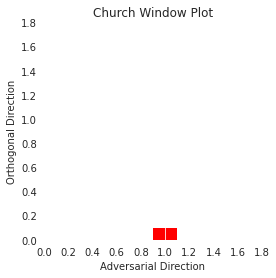

In [29]:
plot_predictions(scipy.stats.mode(PP_aggregate, axis=0)[0][0])

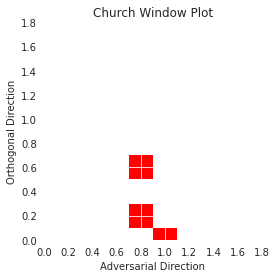

In [33]:
# name = "%s/%s_%s.png"%(save_path, alphanumeric_key, i)
plot_predictions(PP)

In [34]:
# with open()

In [35]:
# ##### Plot ######
# plt.imshow(PP, cmap=custom_cmap)
# plt.xlim([0, 10])
# plt.ylim([0, 10])
# plt.title('Church Window Plot')
# plt.xticks(range(0,10), labels = plot_labels)
# plt.yticks(range(0,10), labels = plot_labels)
# plt.xlabel('Adversarial Direction')
# plt.ylabel('Orthogonal Direction')
# plt.show()

In [36]:
from PIL import Image

In [40]:
save_path = '/om5/user/smadan/differentiable_graphics_ml/other_optimization_methods/church_plots/'

In [41]:
save_path

'/om5/user/smadan/differentiable_graphics_ml/other_optimization_methods/church_plots/'

In [42]:
import os

In [43]:
files = os.listdir(save_path)

In [44]:
all_reduced = np.zeros((5,210,210))
count = 0
for f in files:
    if 'oBohs' in f:
        full_path = "%s/%s"%(save_path, f)
        image = np.array(Image.open(full_path))
        reduced = image[45:255,110:320,1]
        all_reduced[count] = reduced
        count += 1

In [45]:
import scipy

In [46]:
A = scipy.stats.mode(all_reduced)

In [47]:
from matplotlib import colors

custom_cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, custom_cmap.N)

Text(0, 0.5, 'Orthogonal Direction')

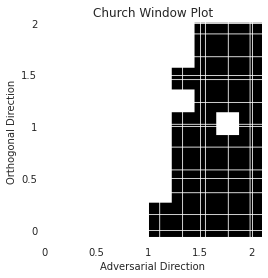

In [49]:
plt.imshow(A[0][0],cmap = 'gray')
# plt.xlabel('adversarial direction')
plt.title('Church Window Plot')
plt.xticks(range(0,210,50), labels = [0,0.5,1,1.5,2])
plt.yticks(range(0,210,50), labels = [2,1.5,1,0.5,0])
plt.xlabel('Adversarial Direction')
plt.ylabel('Orthogonal Direction')